# Second order stochastic methods for CryoEM

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [480]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

In [ ]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

In [ ]:
out_dir = out_dir = '../data/out_dev/'

In [ ]:
nx0 = imgs0.shape[1]
nx_crop = 128
N = 80000
N_px_noise = 48
N_imgs_noise=1000

processed_data = preprocess(imgs0, params0, out_dir, nx_crop = nx_crop, N = N, N_px_noise = N_px_noise, N_imgs_noise = N_imgs_noise)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idxrand = processed_data["idxrand"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[2135].reshape([128,128]))));plt.colorbar()

In [ ]:
del(imgs0)

### Only volume reconstruction for now - SGD

Obervations:

* The loss and grad don't tell us anything about convergence. The loss is about the same after only 100 iterations and after 10 epochs (of 781 iters each), and yet the result is different

In [ ]:
# Apply mask to images
mask2d = mask[0].reshape(-1)
imgs_f = imgs_f * mask2d

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

In [ ]:
alpha = 1e-9

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [ ]:
N_epochs = 20
batch_size = 32
step_size = 1000000 # 1e-3

idxrand = np.random.permutation(N)
idx1 = idxrand[:int(N/2)]
idx2 = idxrand[int(N/2):]
             
grad_func1, loss_func1 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx1], shifts[idx1], ctf_params[idx1], imgs_f[idx1], sigma_noise)
grad_func2, loss_func2 = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx2], shifts[idx2], ctf_params[idx2], imgs_f[idx2], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec1, loss_rec1, grad_rec1 = sgd(grad_func1, loss_func1, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
v_rec2, loss_rec2, grad_rec2 = sgd(grad_func2, loss_func2, int(N/2), x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


In [ ]:
plt.rcParams["figure.figsize"]=12, 12

plt.subplot(1,2,1)
mip_z(np.fft.fftshift(np.abs(v_rec1))); #plt.colorbar()

plt.subplot(1,2,2)
mip_z(np.fft.fftshift(np.abs(v_rec2))); #plt.colorbar()

In [ ]:
v_rec_l1, _ = rescale_larger_grid(v_rec1, x_grid, nx0)
vr_sgd1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l1)))

v_rec_l2, _ = rescale_larger_grid(v_rec2, x_grid, nx0)
vr_sgd2 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l2)))

plt.subplot(1,2,1)
mip_z(vr_sgd1)
#plt.colorbar()

plt.subplot(1,2,2)
mip_z(vr_sgd2)
#plt.colorbar()

plt.rcParams["figure.figsize"]=6, 6


In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_sgd1.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd1.astype(np.float32))
    
with mrcfile.new(f"{out_dir}/v_rec_sgd2.mrc", overwrite=True) as mrc:
    mrc.set_data(vr_sgd2.astype(np.float32))   

#### FSC

In [ ]:
print(v_rec1.shape)
print(v_rec2.shape)
print(x_grid)

In [ ]:
res, fsc, shell_points = calc_fsc(v_rec1, v_rec2, [1, 128])

In [ ]:
plt.plot(res, fsc)

In [ ]:
res_angs = nx0 * pixel_size[0]/res
plt.semilogx(res_angs, fsc)

In [ ]:
fsc

In [ ]:
fsc[10]

In [ ]:
fsc[11]

In [ ]:
res_angs[10]

In [ ]:
res_angs[11]

### Newton's method vs GD vs CG

#### GD - a pain to tune 

In [ ]:
Ngd = 1000

N_epochs = 200
batch_size = Ngd
step_size = 10000 # 1e-3

idx = np.arange(Ngd)

grad_func, loss_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma_noise)

key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

In [ ]:
v_rec_gd, loss_rec_gd, grad_rec_gd = sgd(grad_func, loss_func1, Ngd, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=10)


In [ ]:
plt.plot(loss_rec_gd)

### OASIS

#### Hutchinson's method

The diagonal of a symmetric matrix can be approximated as follows:

$
\text{diag}(A) = \mathbb{E}[z * Az ],
$

where $z$ is a random vector with Rademacher or Gaussian distribution and $*$ represents element-wise multiplication.

Here we're reproducing Figure 1 in the OASIS paper.

In [552]:
n = 100

key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

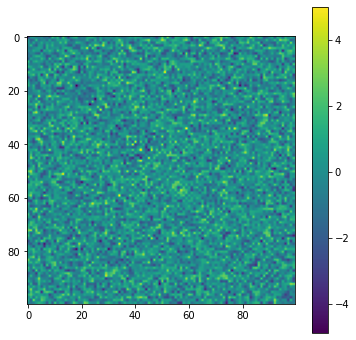

In [553]:
key, subkey = random.split(key)

A = random.normal(subkey, (n,n))
A = A.T + A

plt.imshow(A); plt.colorbar()

In [554]:
iters = 10000

key, subkey = random.split(key)
z = random.rademacher(subkey, (iters, n))

#z * A @ z 

In [555]:
zAz = jax.vmap(lambda zi : zi * (A @ zi))(z)
#plt.imshow(zAz)

In [556]:
d = np.zeros((iters, n))
d[0] = zAz[0]
for i in range(1, iters):
    d[i] = d[i-1] + zAz[i]
    
for i in range(1, iters):
    d[i] = d[i]/(i+1)

In [557]:
err = jnp.mean((d - jnp.diag(A))**2, axis=1)

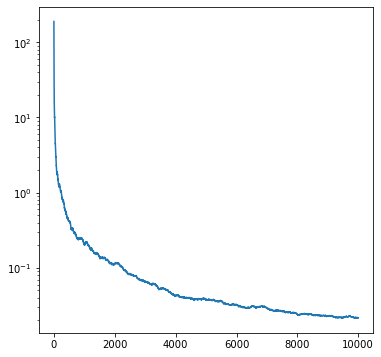

In [558]:
plt.semilogy(err)

#### Hessian-vector product in JaX

In [559]:
key, *subkey = random.split(key, 4)
x0 = random.normal(subkey[0], (n,))
x = random.normal(subkey[1], (n,))
v = random.normal(subkey[2], (n,))

In [560]:
b = A @ x0 
f = lambda x : jnp.mean((A @ x - b)**2)

In [561]:
f(x0)

DeviceArray(0., dtype=float64)

In [562]:
from jax import jvp, grad

# Naive
def hvp0(f, x, v):
    return grad(lambda x : jnp.vdot(grad(f)(x), v))(x)

# forward-over-reverse
def hvp(f, x, v):
    return jvp(jax.grad(f), x, v)[1]

In [563]:
t0 = time.time()
v1 = hvp0(f, x, v).block_until_ready()
print(time.time()-t0)

t0 = time.time()
v2 = hvp(f, (x,), (v,)).block_until_ready()
print(time.time()-t0)

jnp.sum(jnp.abs(v1-v2))

1.35469651222229
0.6434576511383057


DeviceArray(0., dtype=float64)

#### Toy problem

Text(0.5, 1.0, 'Condition number = 326.166125611872')

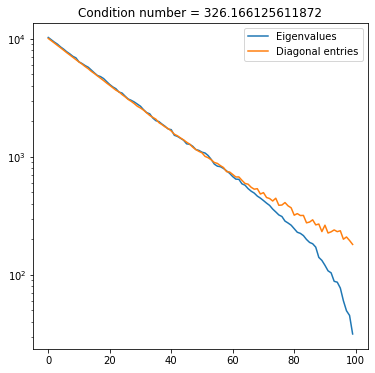

In [564]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))

Adiag = jnp.flip(jnp.logspace(1,2,n))
np.fill_diagonal(A, Adiag)

A = A.T @ A

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort( evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.abs(A.T - A)) == 0)
assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals)
plt.semilogy(jnp.diag(A))
plt.legend(["Eigenvalues", "Diagonal entries"])
plt.title(f"Condition number = {evals[0]/evals[n-1]}")

In [590]:
sig_noise = 1
lam = 0.1

b = A @ x_gt #+ np.random.normal(size=(n,)) * sig_noise

F = lambda x : jnp.mean((A @ x - b)**2) #+ lam * jnp.mean(x**2)
print(f"f(x_gt + 1) = {F(x_gt+1)}")
print(f"f(x_gt) = {F(x_gt)}")

gradF = jax.grad(F)
hessianF = jax.hessian(F)

hvpF = lambda x, v : hvp(F, (x,), (v,))

print(f"gradF(x_gt) = {gradF(x_gt)}")
print(f"hessianF(x_gt) = {hessianF(x_gt)}")


f(x_gt + 1) = 11335342.64774272
f(x_gt) = 0.0
gradF(x_gt) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
hessianF(x_gt) = [[ 2.05928913e+06 -8.77704015e+03  1.67111939e+04 ... -2.33798021e+04
   1.08962949e+03 -1.96863355e+04]
 [-8.77704015e+03  1.88194682e+06  4.31507978e+04 ... -3.62070724e+04
   2.81963165e+04 -1.37202695e+04]
 [ 1.67111939e+04  4.31507978e+04  1.71921460e+06 ... -1.66425561e+04
   1.73256581e+04  9.96639217e+03]
 ...
 [-2.33798021e+04 -3.62070724e+04 -1.66425561e+04 ...  6.40743174e+03
  -7.56985702e+02  6.05919181e+02]
 [ 1.08962949e+03  2.81963165e+04  1.73256581e+04 ... -7.56985702e+02
   4.83702956e+03  5.07061418e+01]
 [-1.96863355e+04 -1.37202695e+04  9.96639217e+03 ...  6.05919181e+02
   5.07061418e+01

In [572]:
def gd(F, gradF, eta, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        w1 = w0 - eta * gradF(w0)
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

def newton(F, gradF, hessianF, w0, N_iter = 20, iter_display = 1):
    loss = []
    for k in range(1, N_iter+1):
        G = gradF(w0)
        H = hessianF(w0)
        
        w1 = w0 - jnp.linalg.inv(H) @ G
        loss_i = F(w1)
        loss.append(loss_i)
        
        w0 = w1
        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
            
    return w1, jnp.array(loss)

In [591]:
N_iter = 10000
eta = 0.0000005 #0.000005 # learning rate
x0 = np.random.randn(*x_gt.shape)

x_gd, loss_gd = gd(F, gradF, eta, x0, N_iter, iter_display = 200)

Iter 200: loss = 53180.158884481396
Iter 400: loss = 20845.912986021107
Iter 600: loss = 11397.470809435945
Iter 800: loss = 7137.227570060723
Iter 1000: loss = 4898.583157592187
Iter 1200: loss = 3605.5125655308843
Iter 1400: loss = 2798.75315219145
Iter 1600: loss = 2261.4351695713153
Iter 1800: loss = 1883.63489459445
Iter 2000: loss = 1606.054540399491
Iter 2200: loss = 1394.795514576242
Iter 2400: loss = 1229.404738626076
Iter 2600: loss = 1096.919988038694
Iter 2800: loss = 988.7607575596595
Iter 3000: loss = 899.0297554682559
Iter 3200: loss = 823.5434885436091
Iter 3400: loss = 759.255154800517
Iter 3600: loss = 703.8970856769889
Iter 3800: loss = 655.7508689918925
Iter 4000: loss = 613.4945447575466
Iter 4200: loss = 576.0980062568841
Iter 4400: loss = 542.7495637118043
Iter 4600: loss = 512.8032660172844
Iter 4800: loss = 485.7404218057594
Iter 5000: loss = 461.14105992658824
Iter 5200: loss = 438.6624861886837
Iter 5400: loss = 418.02299227908617
Iter 5600: loss = 398.989359

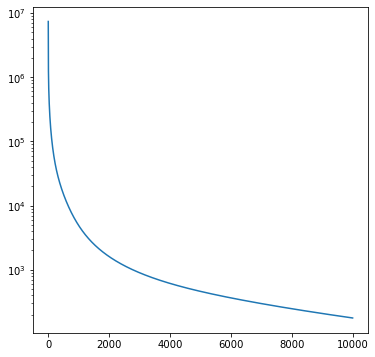

In [592]:
plt.semilogy(loss_gd)

In [593]:
N_iter = 10

x_n, loss_n = newton(F, gradF, hessianF, x0, N_iter, iter_display = 1)

Iter 1: loss = 1.3182142803475538e-20
Iter 2: loss = 7.317478805539899e-25
Iter 3: loss = 6.657289318113849e-25
Iter 4: loss = 4.421861985464134e-25
Iter 5: loss = 3.0784205042757162e-25
Iter 6: loss = 4.386884524015359e-25
Iter 7: loss = 2.9430343024555133e-25
Iter 8: loss = 4.769314193446919e-25
Iter 9: loss = 3.708176369067064e-25
Iter 10: loss = 3.4826404051756525e-25


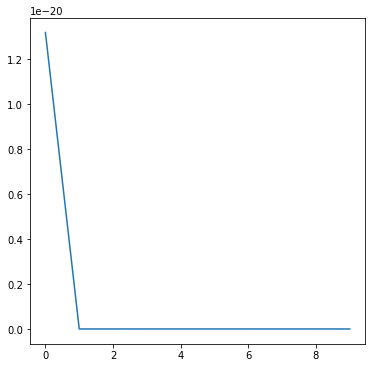

In [594]:
plt.plot(loss_n)

In [595]:
N_iter = 1000

zero = jnp.zeros(x_gt.shape)
Abfun = gradF(zero)

Ab = -jnp.conj(Abfun)
AA = lambda vv : jnp.conj(gradF(vv)) + Ab

x_cg, kk = cg(AA, Ab, x0, N_iter, verbose=True)

  cg iter 0 ||r|| = 2584752.8644482554
  cg iter 200 ||r|| = 185.09626997462206
  cg iter 400 ||r|| = 4.639773375801923
  cg iter 600 ||r|| = 3.0193416306631917e-13
  cg iter 800 ||r|| = 1.090584864840031e-13


In [596]:
F(x_cg)

DeviceArray(9.65259756e-23, dtype=float64)

#### OASIS

In [636]:
# First attempt

def oasis(key, F, gradF, hvpF, w0, eta, D0, beta2, alpha, N_iter = 20, iter_display = 1):
    """OASIS with fixed learning rate, deterministic."""
    
    z = random.rademacher(key, (iters, n)).astype(jnp.float64)
    
    gradFw0 = gradF(w0)
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                      
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta0 * (invDhat0 @ gradFw0)

    loss = []
    for k in range(1, N_iter+1):

        D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1]))
        Dhat1 = jnp.maximum(jnp.abs(D1), alpha)       
        invDhat1 = jnp.diag(1/Dhat1)
        
        w2 = w1 - eta * (invDhat1 @ gradF(w1))
        
        w0 = w1
        w1 = w2

        loss_i = F(w1)
        loss.append(loss_i)        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
    return w1, jnp.array(loss)


def oasis_adaptive(key, F, gradF, hvpF, w0, eta0, D0, beta2, alpha, N_iter = 20, iter_display = 1):
    """OASIS with adaptive learning rate, deterministic."""
    
    z = random.rademacher(key, (iters, n)).astype(jnp.float64)
    
    gradFw0 = gradF(w0)

    theta0 = jnp.inf
    Dhat0 = jnp.maximum(jnp.abs(D0), alpha)
                        
    invDhat0 = jnp.diag(1/Dhat0)
    w1 = w0 - eta0 * (invDhat0 @ gradFw0)
    
    gradFw1 = jax.grad(F)(w1)

    loss = []
    for k in range(1, N_iter+1):

        D1 = beta2 * D0 + (1-beta2) * (z[k-1] * hvpF(w1, z[k-1]))
        Dhat1 = jnp.maximum(jnp.abs(D1), alpha)
        invDhat1 = jnp.diag(1/Dhat1)
        Dhat1 = jnp.diag(Dhat1)
        
        tl = jnp.sqrt(1 + theta0)*eta0
        
        wd = w1-w0
        gfd = gradFw1 - gradFw0
        tr = 1/2 * jnp.sqrt(jnp.vdot(wd, Dhat1 @ wd) / jnp.vdot(gfd, invDhat1 @ gfd))
        
        eta1 = jnp.minimum(tl, tr)
        
        w2 = w1 - eta1 * (invDhat1 @ gradFw1)
        gradFw2 = gradF(w2)

        theta1 = eta1/eta0
        
        w0 = w1
        w1 = w2
        
        eta0 = eta1
        theta0 = theta1
        
        gradFw0 = gradFw1
        gradFw1 = gradFw2

        loss_i = F(w1)
        loss.append(loss_i)        
        if k % iter_display == 0:
            print(f"Iter {k}: loss = {loss_i}")
    return w1, jnp.array(loss)

In [640]:
N_iter = 10000
beta2 = 0.99
eta = 0.1 #0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 #0.1 # 0.01

key, subkey = random.split(key)
x_o, loss_o = oasis(subkey, F, gradF, hvpF, x0, eta, D0, beta2, alpha, N_iter, iter_display = 100)

Iter 100: loss = 116009.83192072621
Iter 200: loss = 50835.904570084334
Iter 300: loss = 30314.646033432597
Iter 400: loss = 20902.314520653632
Iter 500: loss = 15541.134004735164
Iter 600: loss = 12062.934643808583
Iter 700: loss = 9632.890450277591
Iter 800: loss = 7851.398915921229
Iter 900: loss = 6501.65249206097
Iter 1000: loss = 5458.537065540934
Iter 1100: loss = 4639.775167534436
Iter 1200: loss = 3984.2743569423783
Iter 1300: loss = 3453.41616961922
Iter 1400: loss = 3018.8828156111667
Iter 1500: loss = 2659.9692503670544
Iter 1600: loss = 2359.8007835586773
Iter 1700: loss = 2107.920167924548
Iter 1800: loss = 1893.9222147831097
Iter 1900: loss = 1711.366056222827
Iter 2000: loss = 1554.2159581065594
Iter 2100: loss = 1417.5010171910826
Iter 2200: loss = 1298.3542656158957
Iter 2300: loss = 1193.7639745237925
Iter 2400: loss = 1101.5079093841623
Iter 2500: loss = 1019.5409259476664
Iter 2600: loss = 946.475626569622
Iter 2700: loss = 880.9619175242588
Iter 2800: loss = 822.0

In [639]:
N_iter = 10000
beta2 = 0.99
eta0 = 0.1 #0.1/0.001/0.01/0.15
D0 = jnp.diag(hessianF(x0)) # Cheating a bit
                       
alpha = 0.1 # 0.01

key, subkey = random.split(key)
x_oa, loss_oa = oasis_adaptive(subkey, F, gradF, hvpF, x0, eta0, D0, beta2, alpha, N_iter, iter_display = 100)

Iter 100: loss = 11935.591894101708
Iter 200: loss = 3948.801071707809
Iter 300: loss = 1831.4541607834894
Iter 400: loss = 1072.6564258566605
Iter 500: loss = 702.1670317944746
Iter 600: loss = 490.29567381822585
Iter 700: loss = 359.2546611342298
Iter 800: loss = 271.07716406660273
Iter 900: loss = 206.6113800117129
Iter 1000: loss = 158.2847032991941
Iter 1100: loss = 124.04333991897455
Iter 1200: loss = 97.33728456304917
Iter 1300: loss = 76.38574538295182
Iter 1400: loss = 60.550819216935054
Iter 1500: loss = 48.09653495904338
Iter 1600: loss = 38.3093010685694
Iter 1700: loss = 30.32837618137786
Iter 1800: loss = 24.23182536340131
Iter 1900: loss = 19.296322785454162
Iter 2000: loss = 15.665118461816387
Iter 2100: loss = 12.562010631396522
Iter 2200: loss = 10.090528245886444
Iter 2300: loss = 8.127085285098277
Iter 2400: loss = 6.590767153737488
Iter 2500: loss = 5.269441133914456
Iter 2600: loss = 4.253217275768353
Iter 2700: loss = 3.452978159429362
Iter 2800: loss = 2.7898740

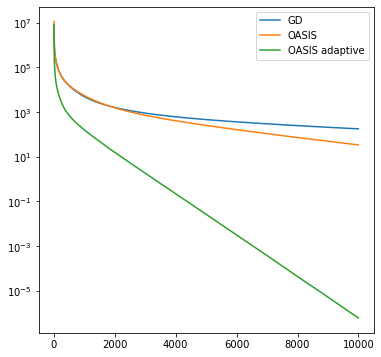

In [641]:
plt.semilogy(loss_gd)
plt.semilogy(loss_o)
plt.semilogy(loss_oa)


plt.legend(["GD", "OASIS", "OASIS adaptive"])

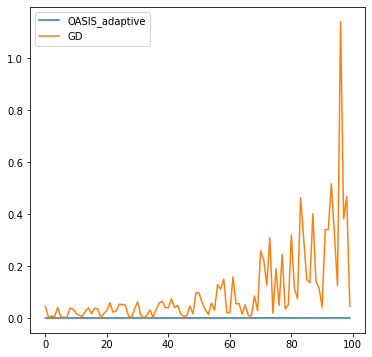

In [642]:
idx = n
plt.plot(jnp.abs((x_gt-x_oa)[:idx]))

plt.plot(jnp.abs((x_gt-x_gd)[:idx]))
#plt.plot(jnp.abs((x_gt-x_n)[:idx]))
#plt.plot(jnp.abs((x_gt-x_o)[:idx]))

#plt.legend(["GD", "Newton", "OASIS", "OASIS_adaptive"])
#plt.legend(["GD", "OASIS", "OASIS_adaptive"])
plt.legend([ "OASIS_adaptive", "GD",])

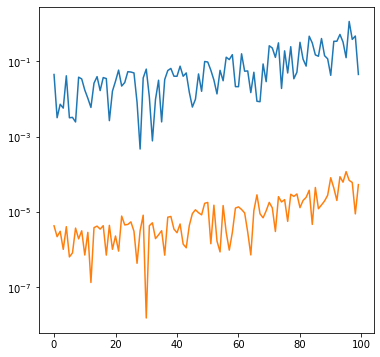

In [643]:
plt.semilogy(jnp.abs(x_gt-x_gd))
plt.semilogy(jnp.abs(x_gt-x_oa))


In [645]:
print(jnp.mean(jnp.abs(x_gt-x_n)))
print(jnp.mean(jnp.abs(x_gt-x_cg)))
print(jnp.mean(jnp.abs(x_gt-x_gd)))
print(jnp.mean(jnp.abs(x_gt-x_o)))
print(jnp.mean(jnp.abs(x_gt-x_oa)))

5.91263149551935e-16
1.0650340852291774e-13
0.10058772162344029
0.1035551045554131
1.3804452604077606e-05


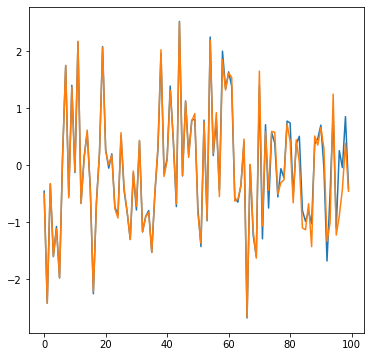

In [646]:
plt.plot(x_gt)
plt.plot(x_gd)

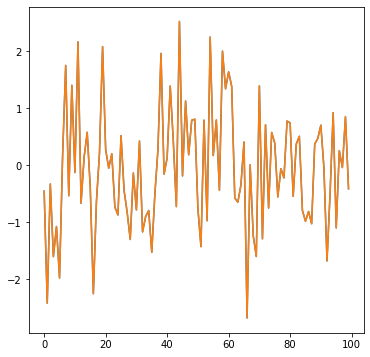

In [647]:
plt.plot(x_oa)
plt.plot(x_gt)


### Stochastic - sum of operators

In [ ]:
key, *subkey = random.split(key, 4)

x_gt = random.normal(subkey[0], (n,))

A = np.random.normal(size = (n,n))

Adiag = jnp.flip(jnp.logspace(1,2,n))
np.fill_diagonal(A, Adiag)

A = A.T @ A

evals, evecs = np.linalg.eig(A)
evals = np.flip(np.sort( evals))


assert(jnp.sum(evals < 0) == 0)
assert(jnp.max(jnp.abs(A.T - A)) == 0)
assert(jnp.sum(jnp.abs(A@A.T - A.T@ A)) == 0)


plt.semilogy(evals)
plt.semilogy(jnp.diag(A))
plt.legend(["Eigenvalues", "Diagonal entries"])
plt.title(f"Condition number = {evals[0]/evals[n-1]}")